# Create a Hovmoeller diagram of high and low frequency winds

In [1]:
from importlib import reload
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy as ctp
import locale

from latgmm.utils import utenso, preproc, eof, utdata, utstats, metric
import latgmm.geoplot as gpl

locale.setlocale(locale.LC_TIME, "en_US.utf8")
plt.style.use("../../paper.mplstyle")

In [2]:
u10_hf = xr.open_dataset("../../data/additional_data/6-hourly/era5_u10_anom_HF_1940_2021_5N5S_130E80W_1deg.nc")['u10_anom_HF']
u10_hf = u10_hf.assign_coords(lon=(((u10_hf.lon + 180) % 360) - 180))
u10_hf = preproc.set_antimeridian2zero(u10_hf)
u10_lf = xr.open_dataset("../../data/additional_data/6-hourly/era5_u10_anom_LF_1940_2021_5N5S_130E80W_1deg.nc")['u10_anom_LF']
u10_lf = u10_lf.assign_coords(lon=(((u10_lf.lon + 180) % 360) - 180))
u10_lf = preproc.set_antimeridian2zero(u10_lf)

u10_ds = xr.merge([u10_hf, u10_lf])

Set the dateline to the new longitude zero.
Set the dateline to the new longitude zero.


Check data

{'ax': <GeoAxes: >,
 'im': <cartopy.mpl.geocollection.GeoQuadMesh at 0x7efc5cb172d0>,
 'gl': <cartopy.mpl.gridliner.Gridliner at 0x7efc5caf46d0>,
 'cb': <matplotlib.colorbar.Colorbar at 0x7efc5c92ba90>}

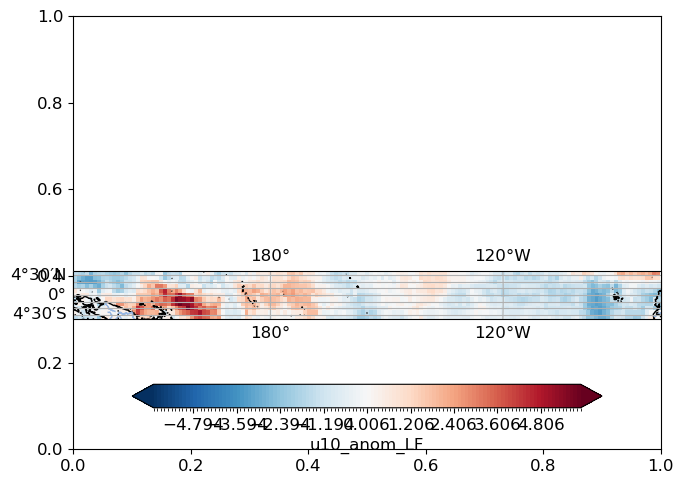

In [3]:
gpl.plot_map(u10_lf.isel(time=100), central_longitude=180, ctp_projection='Robinson')

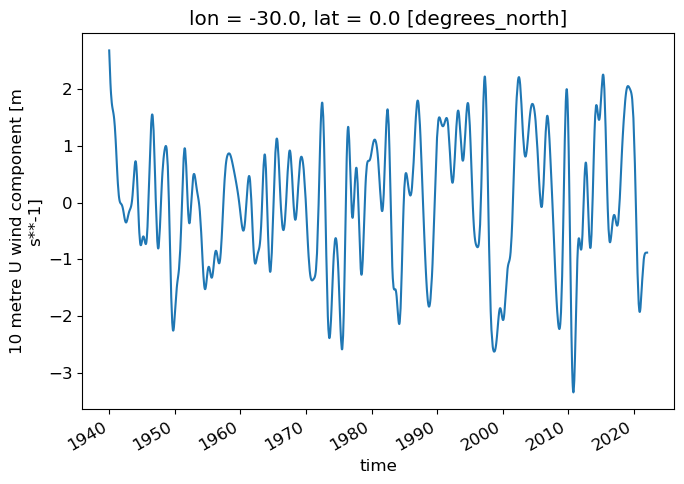

In [4]:
u10_lf.isel(lat=5, lon=20).plot()

In [5]:
# Load SST data
# =======================================================================================
lon_range=[130, -70]
lat_range=[-32, 32]

dirpath = "../../data/sst/monthly"
sst_fname = dirpath+"/sea_surface_temperature_era5_monthly_sp_1940-2022_1.0x1.0.nc"

# SST anomalies
ssta = preproc.process_data(
        sst_fname, vars=['sst'], antimeridian=True,
        climatology='month', normalization=None, detrend_from=1950, 
        lon_range=lon_range, lat_range=lat_range,
)['ssta']


Sort longitudes and latitudes in ascending order, respectively
Process sst:
Roll longitudes.
Set the dateline to the new longitude zero.
Get selected area: lon=[-50 110], lat=[-32, 32]!
Detrend and compute anomalies:


## Single event Hovmoeller

Paperplot of EP and EEN events:

/tmp/ipykernel_100857/2723789969.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../../output/reanalysis/pcgmm/hovmoeller/"
/mnt/qb/work/goswami/jschloer46/software/mamba/envs/phdenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


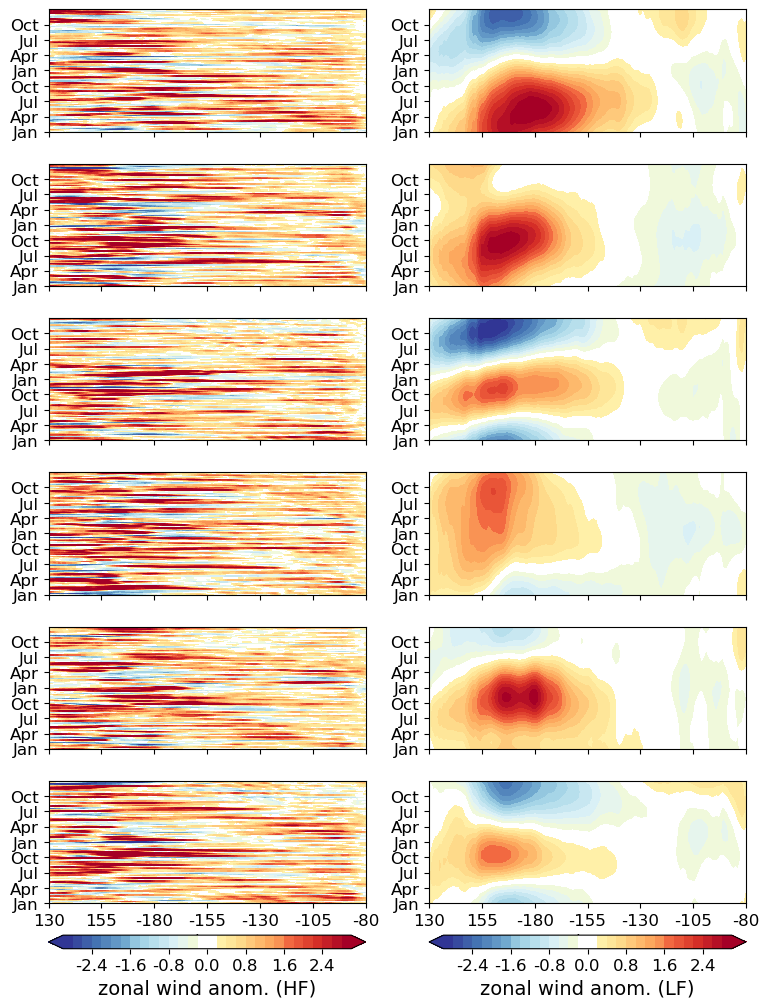

In [6]:
from matplotlib.ticker import FuncFormatter
reload(vpl)

events = [
    [1987, 1988],
    [2002, 2003],
    [2009, 2010],
    [2018, 2019],
    [1994, 1995],
    [2006, 2007],
]
plotspec={
    'u10_anom_HF': dict(cmap='RdYlBu_r', vmin=-3, vmax=3, step=.2, centercolor="#FFFFFF"),
    'u10_anom_LF': dict(cmap='RdYlBu_r', vmin=-3, vmax=3, step=.2, centercolor="#FFFFFF"),
}

#events = [
#    [1982, 1983],
#    [1997, 1998],
#    [2015, 2016],
#]
#plotspec={
#    'u10_anom_HF': dict(cmap='RdYlBu_r', vmin=-5, vmax=5, step=.5, centercolor="#FFFFFF"),
#    'u10_anom_LF': dict(cmap='RdYlBu_r', vmin=-5, vmax=5, step=.5, centercolor="#FFFFFF"),
#}

lat_range=[-5, 5]

n_columns = len(u10_ds.data_vars) 
n_rows = len(events)
height_ratios = [9]*(n_rows)
height_ratios.append(1)
fig = plt.figure(figsize=(n_columns*4.5, n_rows*2 + 0.2))
gs = fig.add_gridspec(n_rows + 1, n_columns,
                      height_ratios=height_ratios,
                      hspace=0.3, wspace=0.2)

central_longitude = 180
proj = ctp.crs.PlateCarree(central_longitude=central_longitude)

axs = []
ims = []
for i in range(n_rows):
    for j in range(n_columns):
        var = list(u10_ds.data_vars)[j]
        lat_mean = u10_ds[var].sel(
            time=slice(f"{events[i][0]}-01-01", f"{events[i][1]}-12-30"),
            lat=slice(lat_range[0], lat_range[1])
        ).mean(dim='lat')

        ax = fig.add_subplot(gs[i, j])
        im = gpl.plot_hovmoeller(lat_mean, x='lon', y='time',
                                 ax=ax, **plotspec[var], add_bar=False)

        # X-axis
        ax.set_xlim(None, 100)

        if i < n_rows -1:
            ax.set_xticklabels([])
        else:
            xaxis_formatter = FuncFormatter(lambda x, pos: f'{np.where(x < 0, (x % 180),(x % 180 - 180)):.0f}')
            ax.xaxis.set_major_formatter(xaxis_formatter)
            ax.set_xlabel('lon')
        
        # Y-axis to month
        ax.yaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))

        axs.append(ax)
        ims.append(im)
    
# Add figure numbering
#_ = gpl.enumerate_subplots(np.array(axs).T, pos_x=0.02, pos_y=1.05, fontsize=14)
        

# Shared colorbar
cbar_labels = ['zonal wind anom. (HF)', 'zonal wind anom. (LF)']
for j in range(n_columns):
    ax = fig.add_subplot(gs[-1, j])
    cbar = plt.colorbar(ims[j]['im'], orientation='horizontal', shrink=0.9,
                        cax=ax, extend='both')
    cbar.set_label(cbar_labels[j], size=14)

    formatter = FuncFormatter(lambda x, pos: f'{x:.1f}')
    cbar.ax.xaxis.set_major_formatter(formatter)
    cbar.ax.yaxis.set_major_formatter(formatter)

plt.savefig("../../output/reanalysis/pcgmm/hovmoeller/"
            + f"event_plots_{np.array(events)[:,0]}_wwb.png",
            dpi=300, bbox_inches='tight')

## Weighted Hovmoeller

In [7]:
# Load weights
weight_events = xr.open_dataset(
    "../../output/reanalysis/pcgmm/pcgmm_weights_events_mean_sst.nc"
)['p_c_given_x']
gmm_order = weight_events.attrs['gmm_sort']

In [8]:
from tqdm import tqdm
import scipy.stats as stats
from joblib import Parallel, delayed

def weighted_mean_over_years(ds: xr.Dataset, weights: xr.DataArray,
                             mon_first_year: int=1, mon_second_year: int=12, 
                             ) -> xr.Dataset:
    """Compute a weighted mean over all events for a time-period around
    the definition of the weight.

    Args:
        ds (xr.Dataset): _description_
        weights (xr.DataArray): _description_
        mon_first_year (int, optional): _description_. Defaults to 1.
        mon_second_year (int, optional): _description_. Defaults to 12.

    Returns:
        xr.Dataset: _description_
    """
    # Make sure dstaset for composites are on the same time points as weights
    ds['time'] = np.array(ds['time'].data, dtype='datetime64[h]')
    weights['time'] = np.array(weights['time'].data, dtype='datetime64[h]')

    tmax = ds['time'].max() if ds['time'].max(
    ) < weights['time'].max() else weights['time'].max()
    tmin = ds['time'].min() if ds['time'].min(
    ) > weights['time'].min() else weights['time'].min()
    weights = weights.sortby(weights['time'])
    weights = weights.sel(time=slice(tmin.data, tmax.data))
    ds = ds.sel(time=slice(tmin.data, tmax.data))

    # Create weighted mean for each ENSO events time period
    weighted_mean = []
    for var in list(ds.data_vars):
        weighted_mean_var = []
        da = ds[var]

        years = np.unique(np.array(weights['time'].data, dtype='datetime64[Y]'))[:-2]
        data_years = []
        for y in years:
            # Select time-period each year
            tstart = np.datetime64(f"{y}-{mon_first_year:02d}-01", 'D')
            tend = np.datetime64(f"{y+1}-{mon_second_year:02d}-30", 'D') 
            da_year = da.sel(time=slice(tstart, tend))
            # Remove 29th of February if it's a leap year
            da_year = da_year.where(~((da_year.time.dt.month == 2) & (da_year.time.dt.day == 29)), drop=True)

            data_years.append(da_year.data)

        # Create Dataarray
        common_time = da_year['time'].data
        data_years = xr.DataArray(np.array(data_years),
                                  coords={'samples': np.arange(len(years)),
                                          'time': common_time,
                                          'lat': ds['lat'], 'lon': ds['lon']})
        
        # Loop over categories
        for i, k in enumerate(weights['classes'].data):
            weight_class = weights.sel(classes=k)

            weight_years = [] 
            for y in years:
                weight_years.append(weight_class.sel(time=f"{y}-12-01", method='nearest').data)

            weight_years = xr.DataArray(np.array(weight_years),
                                        coords={'samples': np.arange(len(years))})

            # Weighted years
            da_weighted = data_years.weighted(weight_years)
            mean = da_weighted.mean(dim='samples')
            weighted_mean_var.append(mean)

        # Concat classes
        weighted_mean_var = xr.concat(weighted_mean_var, dim=weights['classes'])
        weighted_mean_var.name = var
        weighted_mean.append(weighted_mean_var)


    # Merge different vars
    weighted_mean = xr.merge(weighted_mean)

    return weighted_mean

Compute weighted mean over time.

In [9]:
mon_first_year = 1
mon_second_year = 12
lats = [-5, 5]
weighted_mean = weighted_mean_over_years(
    u10_ds, weights=weight_events, 
    mon_first_year=mon_first_year, mon_second_year=mon_second_year,
    )
weighted_lat_mean = weighted_mean.sel(lat=slice(lats[0], lats[1])).mean(dim='lat')

/tmp/ipykernel_100857/648991370.py:21: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds['time'] = np.array(ds['time'].data, dtype='datetime64[h]')
/tmp/ipykernel_100857/648991370.py:21: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting 

/mnt/qb/work/goswami/jschloer46/software/mamba/envs/phdenv/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/mnt/qb/work/goswami/jschloer46/software/mamba/envs/phdenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


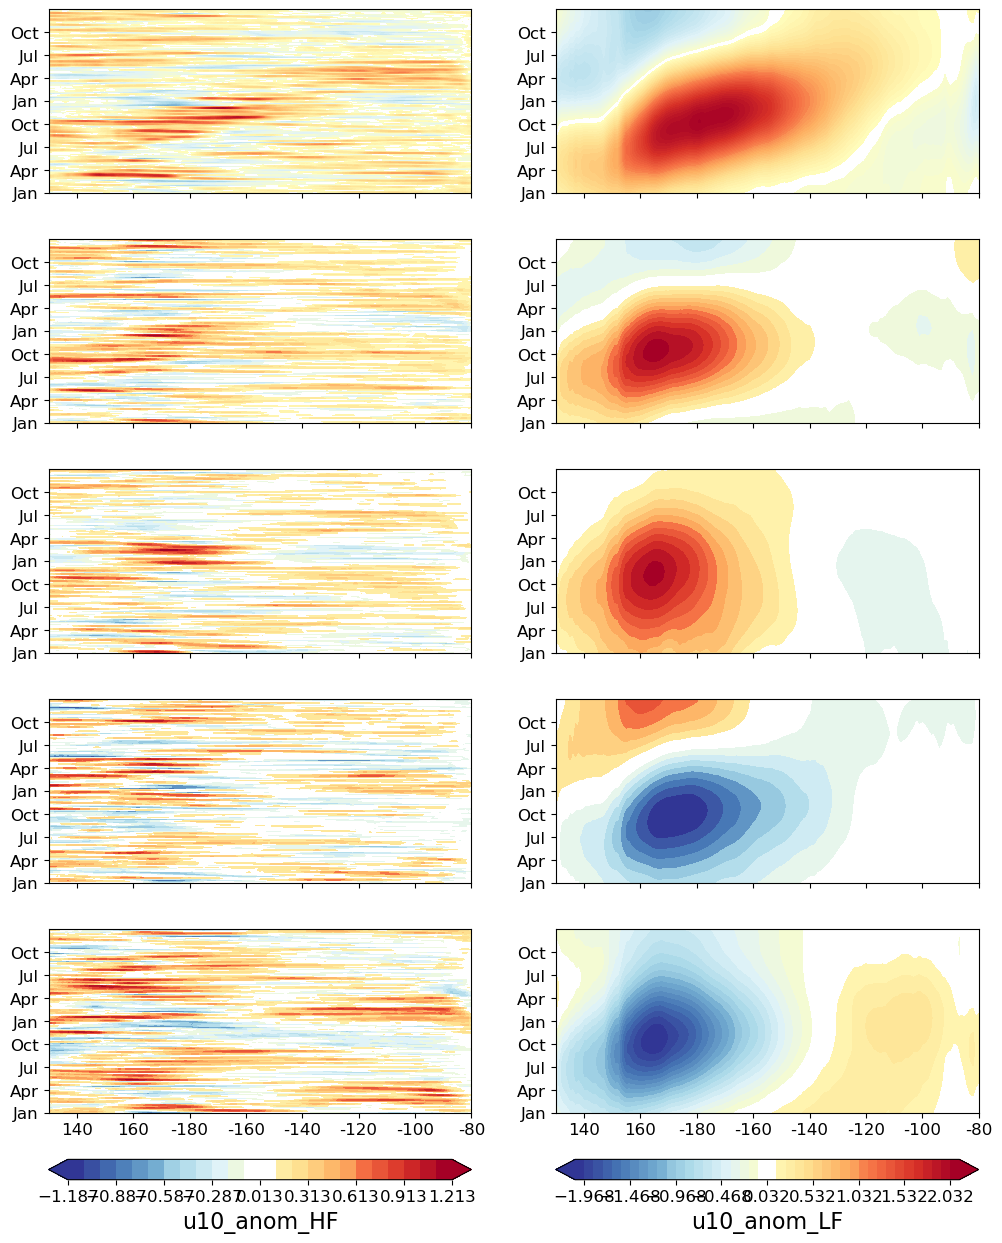

In [10]:
# Plotting
plotspec={
    'u10_anom_HF': dict(cmap='RdYlBu_r', vmin=None, vmax=None, step=.1, centercolor="#FFFFFF"),
    'u10_anom_LF': dict(cmap='RdYlBu_r', vmin=None, vmax=None, step=.1, centercolor="#FFFFFF"),
}
n_columns = len(weighted_lat_mean.data_vars)
n_rows = len(weighted_lat_mean['classes'])
height_ratios = [9]*(n_rows)
height_ratios.append(1)
fig = plt.figure(figsize=(n_columns*6, n_rows*3 + 0.2))
gs = fig.add_gridspec(n_rows + 1, n_columns,
                      height_ratios=height_ratios,
                      hspace=0.3, wspace=0.2)
axs = []
for j in range(n_columns):
    for i in range(n_rows):
        idx = gmm_order[i] + 1
        var = list(weighted_lat_mean.data_vars)[j]
        lat_mean = weighted_lat_mean[var].sel(classes=idx)
        ax = fig.add_subplot(gs[i, j])
        
        im = gpl.plot_hovmoeller(lat_mean, x='lon', y='time',
                                 ax=ax, **plotspec[var], add_bar=False,
                                 cbkwargs=dict(orientation='vertical', shrink=0.8))

        # X-axis
        ax.set_xlim(None, 100)
        xaxis_formatter = FuncFormatter(lambda x, pos: f'{np.where(x < 0, (x % 180),(x % 180 - 180)):.0f}')
        ax.xaxis.set_major_formatter(xaxis_formatter)
        
        if i < n_rows -1:
            ax.set_xticklabels([])
        
        # Y-axis to month
        ax.yaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))
        

    # Shared colorbar
    ax = fig.add_subplot(gs[-1, j])
    cbar = plt.colorbar(im['im'], orientation='horizontal', shrink=0.3,
                        cax=ax, extend='both')
    cbar.set_label(f"{var}", size=16)


Sample data and compute means of neutral years.

In [11]:
f_sst = sst_fname
null_hypothesis = 'neutral'
n_samples_mean = 100
n_samples_time = 12

# Null hypothesis
enso_classes = utenso.get_enso_flavors_obs(
    definition='N3N4', fname=f_sst, vname='sst', climatology='month',
    month_range=[12, 2],
)
if null_hypothesis == 'neutral':
    # Neutral years as null hypothesis
    time_snippets_null = np.array(
        [enso_classes.loc[enso_classes['type'] == 'Normal']['start'],
         enso_classes.loc[enso_classes['type'] == 'Normal']['end']]
    ).T
elif null_hypothesis == 'all':
    # All winters as null hypothesis
    time_snippets_null = np.array(
        [enso_classes['start'],
         enso_classes['end']]
    ).T
else:
    raise ValueError(f"Unknown null hypothesis: {null_hypothesis}")

samples_null = []
for var in u10_ds.data_vars:
    da = u10_ds[var]

    # Select years and rearrange
    years = np.unique(np.array(time_snippets_null[:,0], dtype='datetime64[Y]'))[:-1]
    print(f"Number of years: {len(years)}")
    da_null = []
    for y in years:
        # Select time-period each year
        tstart = np.datetime64(f"{y}-{mon_first_year:02d}-01", 'D')
        tend = np.datetime64(f"{y+1}-{mon_second_year:02d}-30", 'D') 
        da_year = da.sel(time=slice(tstart, tend))
        # Remove 29th of February if it's a leap year
        da_year = da_year.where(~((da_year.time.dt.month == 2) & (da_year.time.dt.day == 29)), drop=True)

        da_null.append(da_year.data)

    # Create Dataarray
    common_time = da_year['time'].data
    da_null = xr.DataArray(np.array(da_null),
                              coords={'years': np.arange(len(years)),
                                      'time': common_time,
                                      'lat': u10_ds['lat'], 'lon': u10_ds['lon']})

    # Sample means from null hypothesis
    samples_null_var = []
    for n in range(n_samples_mean):
        samples_idx = np.random.choice(da_null['years'], size=n_samples_time,
                                        replace=True)
        samples_null_var.append(da_null.sel(
            years=samples_idx).mean(dim='years'))

    samples_null_var = xr.concat(samples_null_var, dim='samples')
    samples_null_var.name = var
    samples_null.append(samples_null_var)

samples_null = xr.merge(samples_null)
# Compute lat mean for hovmoeller
samples_null_lat_mean = samples_null.sel(lat=slice(lats[0], lats[1])).mean(dim='lat')

Sort longitudes and latitudes in ascending order, respectively
Number of years: 25
Number of years: 25


Statistical significance

In [12]:
alpha = 0.05
multiple_testing='dunn'

masks = []
pvalues = []
for var in list(weighted_lat_mean.data_vars):
    print(f"Percentile of score for {var}")
    # Compute poc in parallel for classes 
    n_processes = len(weighted_lat_mean['classes'])
    results = Parallel(n_jobs=5)(
        delayed(utstats.percentile_of_scores)(
            samples_null_lat_mean[var], weighted_lat_mean[var].isel(classes=i), 
            stackdim=['time', 'lon'], id=i)
        for i in tqdm(range(n_processes))
    )
    # Read results
    indices = []
    pvals = []
    for r in results:
        p, i = r
        indices.append(i)
        pvals.append(p)
    pvals = xr.concat(pvals, dim=weighted_lat_mean['classes'][indices])
    pvalues.append(pvals)

    mask_var = []
    for k in pvals['classes']:
        mask_var.append(utstats.field_significance_mask(
            pvals.sel(classes=k), stackdim=('time', 'lon'), alpha=alpha, corr_type=multiple_testing)
        )
    # Concatenate along classes-dim
    mask_var = xr.concat(mask_var, dim=pvals['classes'])
    mask_var.name = var
    masks.append(mask_var)

pvalues = xr.merge(pvalues)
mask = xr.merge(masks)


Percentile of score for u10_anom_HF


100%|██████████| 5/5 [00:00<00:00,  5.62it/s]


Percentile of score for u10_anom_LF


100%|██████████| 5/5 [00:00<00:00, 2158.45it/s]


In [21]:
mask.to_netcdf("../../output/reanalysis/pcgmm/hovmoeller/mask_hf_lf.nc")

Plot weighted hovmoeller averages

/tmp/ipykernel_100857/3283463551.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../../output/reanalysis/pcgmm/hovmoeller/"
/mnt/qb/work/goswami/jschloer46/software/mamba/envs/phdenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


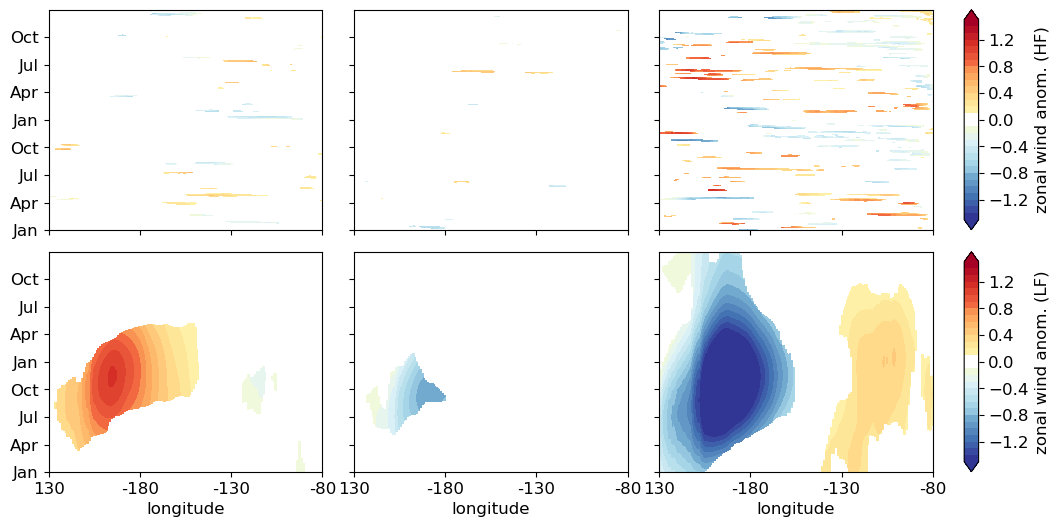

In [17]:
# Plotting
plotspec={
    'u10_anom_HF': dict(cmap='RdYlBu_r', vmin=-1.5, vmax=1.5, step=.1, centercolor="#FFFFFF"),
    'u10_anom_LF': dict(cmap='RdYlBu_r', vmin=-1.5, vmax=1.5, step=.1, centercolor="#FFFFFF"),
}

n_rows = len(weighted_lat_mean.data_vars)
n_columns = len(weighted_lat_mean['classes']) - 2
width_ratios = [19]*(n_columns)
width_ratios.append(1)
fig = plt.figure(figsize=(12, n_rows*3))
gs = fig.add_gridspec(n_rows, n_columns+1, width_ratios=width_ratios,
                      hspace=0.1, wspace=0.15)
axs = []
for i in range(n_rows):
    for j in range(n_columns):
        idx = gmm_order[j+2] + 1
        var = list(weighted_lat_mean.data_vars)[i]
        lat_mean = weighted_lat_mean[var].sel(classes=idx)
        # Statistical significance
        lat_mean_masked = xr.where(mask[var].sel(classes=idx) == True, lat_mean, np.nan)
        ax = fig.add_subplot(gs[i, j])
        
        im = gpl.plot_hovmoeller(lat_mean_masked, x='lon', y='time',
                                 ax=ax, **plotspec[var], add_bar=False)

        # X-axis
        ax.set_xlim(None, 100)
        if i < n_rows -1:
            ax.set_xticklabels([])
        else:
            xaxis_formatter = FuncFormatter(lambda x, pos: f'{np.where(x < 0, (x % 180),(x % 180 - 180)):.0f}')
            ax.xaxis.set_major_formatter(xaxis_formatter)
            ax.set_xlabel('longitude') 
        
        # Y-axis to month
        if j > 0:
            ax.set_yticklabels([])
        else:
            ax.yaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))

        axs.append(ax)
        ims.append(im)
    
    # Shared colorbar
    ax = fig.add_subplot(gs[i, -1])
    cbar = plt.colorbar(im['im'], orientation='vertical', shrink=0.3,
                        cax=ax, extend='both')
    cbar_labels = ['zonal wind anom. (HF)', 'zonal wind anom. (LF)']
    cbar.set_label(cbar_labels[i], size=12)

plt.savefig("../../output/reanalysis/pcgmm/hovmoeller/"
            + f"SI_weighted_mean_wwb_pos-test_null-{null_hypothesis}_alpha-{alpha}"
            + f"_n-{n_samples_mean}_t-{n_samples_time}_multitest_{multiple_testing}.png",
            dpi=300, bbox_inches='tight')

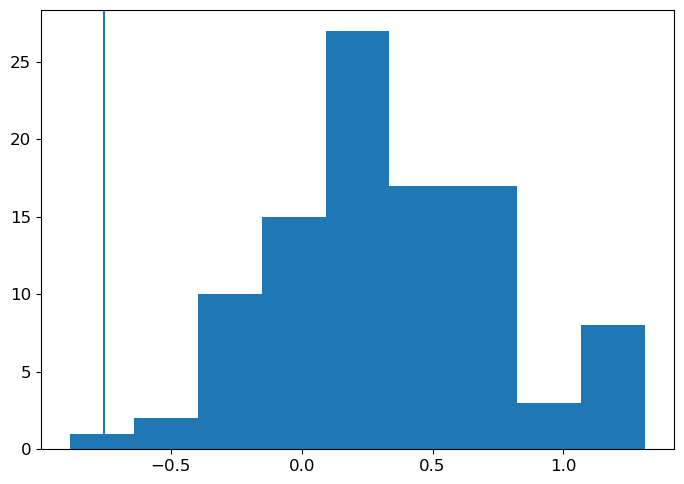

In [14]:
idx_lon = 50
idx_time = 10
var = 'u10_anom_HF'
fig, ax = plt.subplots()
ax.hist(samples_null_lat_mean[var].isel(lon=idx_lon, time=idx_time).data, bins='auto' )
ax.axvline(weighted_lat_mean[var].isel(lon=idx_lon, time=idx_time, classes=i).data)
#ax.set_xlim(-2, 2)

## Paperplot

/tmp/ipykernel_100857/3110479151.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../../output/reanalysis/pcgmm/hovmoeller/"
/mnt/qb/work/goswami/jschloer46/software/mamba/envs/phdenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


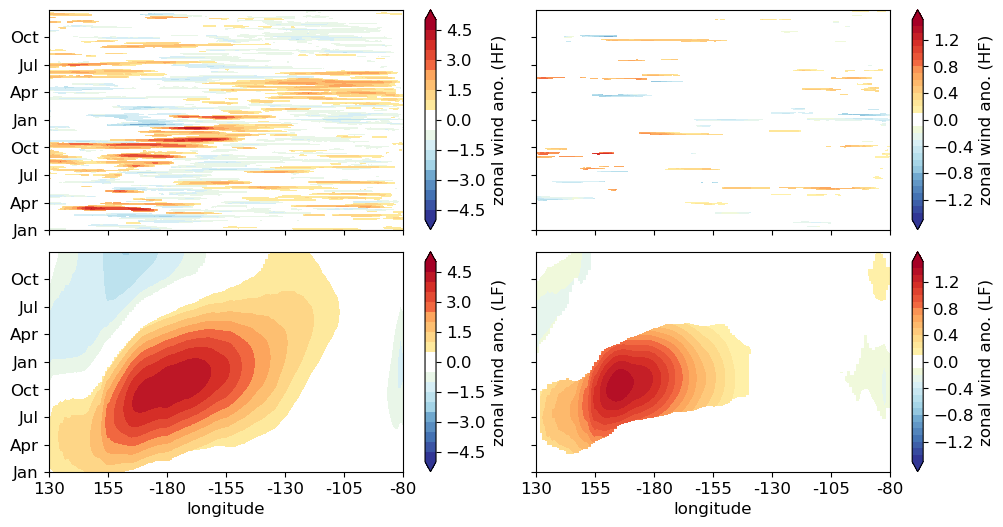

In [20]:
# Plotting
reload(vpl)
plotspec = [
    {'u10_anom_HF': dict(cmap='RdYlBu_r',vmin=-5, vmax=5, step=.5, centercolor="#FFFFFF"),
    'u10_anom_LF': dict(cmap='RdYlBu_r', vmin=-5, vmax=5, step=.5, centercolor="#FFFFFF")},
    {'u10_anom_HF': dict(cmap='RdYlBu_r',vmin=-1.5, vmax=1.5, step=.1, centercolor="#FFFFFF"),
    'u10_anom_LF': dict(cmap='RdYlBu_r', vmin=-1.5, vmax=1.5, step=.1, centercolor="#FFFFFF")}
]

n_columns = 2
n_rows = len(weighted_lat_mean.data_vars) #len(weighted_lat_mean['classes'])
fig = plt.figure(figsize=(12, n_rows*3))
gs = fig.add_gridspec(n_rows, n_columns,
                      hspace=0.1, wspace=0.1)
axs = []
ims = []
for i in range(n_rows):
    for j in range(n_columns):
        idx = gmm_order[j] + 1
        var = list(weighted_lat_mean.data_vars)[i]
        lat_mean = weighted_lat_mean[var].sel(classes=idx)
        lat_mean_masked = xr.where(mask[var].sel(classes=idx) == True, lat_mean, np.nan)
        ax = fig.add_subplot(gs[i, j])

        if j == 0:
            plkwargs = plotspec[0]
        else:
            plkwargs = plotspec[1]
        
        im = gpl.plot_hovmoeller(lat_mean_masked, x='lon', y='time',
                                 ax=ax, **plkwargs[var], add_bar=True,
                                 cbkwargs=dict(orientation='vertical', shrink=1.0))
        # X-axis
        ax.set_xlim(None, 100)
        if i < n_rows -1:
            ax.set_xticklabels([])
        else:
            xaxis_formatter = FuncFormatter(lambda x, pos: f'{np.where(x < 0, (x % 180),(x % 180 - 180)):.0f}')
            ax.xaxis.set_major_formatter(xaxis_formatter)
            ax.set_xlabel('longitude') 
        
        # Y-axis to month
        if j > 0:
            ax.set_yticklabels([])
        else:
            ax.yaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))
        
        axs.append(ax)
        ims.append(im)

        # Colorbar labels
        if var == 'u10_anom_HF':
            formatter = FuncFormatter(lambda x, pos: f'{x:.1f}')
            im['cb'].set_label(f"zonal wind ano. (HF)", size=12)
        elif var == 'u10_anom_LF':
            formatter = FuncFormatter(lambda x, pos: f'{x:.1f}')
            im['cb'].set_label(f"zonal wind ano. (LF)", size=12)



# Add figure numbering
# _ = gpl.enumerate_subplots(np.array(axs).T, pos_x=0.02, pos_y=.9, fontsize=14)
plt.savefig("../../output/reanalysis/pcgmm/hovmoeller/"
            + f"weighted_mean_wwb_pos-test_null-{null_hypothesis}_alpha-{alpha}"
            + f"_n-{n_samples_mean}_t-{n_samples_time}_multitest_{multiple_testing}.png",
            dpi=300, bbox_inches='tight')